In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [2]:
from datetime import datetime, timedelta
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim

pd.options.mode.chained_assignment = None

#------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df
    
    #Load file names for user
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]
    
    usr_trejec_df.Timestamp = pd.to_datetime(usr_trejec_df.Timestamp)
    
    usr_trejec_df.index = usr_trejec_df['Timestamp']
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()
    
     #add columns to user trajectory dataframe
    #1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    #restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time

    #sort values based on timestamp
    usr_trejec_df = usr_trejec_df.sort_values(['Timestamp'])
    #reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)
    
    #some test columns
    #distance between consicutive points to for further checks
    usr_trejec_df['Distance(Km)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Distance(Km)'] = (meters(usr_trejec_df.loc[i, 'Latitude'],
                                                    usr_trejec_df.loc[i, 'Longitude'],
                                                   usr_trejec_df.loc[i+1, 'Latitude'],
                                                   usr_trejec_df.loc[i+1, 'Longitude'])) / 1000
    #time difference between two points
    usr_trejec_df['Time(Hr)'] = 0
    for i in range(0, len(usr_trejec_df)-1):
        usr_trejec_df.loc[i+1, 'Time(Hr)'] = (usr_trejec_df.loc[i+1, 'Timestamp'] -
                                              usr_trejec_df.loc[i, 'Timestamp']).seconds/3600
    #speed                                    
    usr_trejec_df['Speed(Km/Hr)'] = usr_trejec_df['Distance(Km)'] / usr_trejec_df['Time(Hr)']
    
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour
    
    #distance clusters
    usr_trejec_df['DistClus'] = 0
    usr_trejec_df['ClusDur'] = 0
    last_hr =  usr_trejec_df['Hour'][0]
    clusid = 0
    i = 0

    while i < len(usr_trejec_df)-1:
        clusid+=1
        
        #update the cluster duration
        if i != 0:
            usr_trejec_df.loc[i-1, 'ClusDur']= (usr_trejec_df.loc[i-1, 'Timestamp'] - 
                                            usr_trejec_df.loc[i-curr_clus_count, 'Timestamp']).seconds/60
        curr_clus_count = 1
        
        #add current cluster to mean values
        array_lat = usr_trejec_df.loc[i,'Latitude']
        array_lon = usr_trejec_df.loc[i,'Longitude']
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)
        
        usr_trejec_df.loc[i, 'DistClus'] = clusid
        for j in range(i+1, len(usr_trejec_df)):
            #if the hour changes, stop j loop
            if usr_trejec_df.loc[j, 'Hour'] != last_hr:
                last_hr =  usr_trejec_df.loc[j, 'Hour']
                i=j
                break
            else:
                if meters(new_lat_mean, 
                           new_lon_mean, 
                           usr_trejec_df.loc[j,'Latitude'], 
                           usr_trejec_df.loc[j,'Longitude'])<= staypts_d_thrhld:
                        curr_clus_count+=1
                        
                        array_lat= np.append(array_lat, usr_trejec_df.loc[j,'Latitude'])
                        array_lon= np.append(array_lon, usr_trejec_df.loc[j,'Longitude'])
                        new_lat_mean = np.mean(array_lat)
                        new_lon_mean = np.mean(array_lon)
        
                        usr_trejec_df.loc[j, 'DistClus'] = usr_trejec_df.loc[i, 'DistClus']
                        
                else:
                    i=j
                    break
        i=j
        

    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df['Timestamp'].dt.weekday_name

    usr_trejec_df['StayPoint'] = -1 # 1 if it is a staypoint, else 0
    usr_trejec_df['StayptId'] = -1
    usr_trejec_df['StayMeanLat'] = -1.0
    usr_trejec_df['StayMeanLon'] = -1.0
    usr_trejec_df['StateId'] = -1
    
    #remove columns not used/required
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis = 1)
    
    file_name = usr_directory + "/input_trj_data.csv"
    usr_trejec_df.to_csv(file_name, sep='\t', encoding='utf-8')
        
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#------------------------------------------------------------------------------------
def setting_for_staypoint(row, count):
    global usr_trejec_df
    global staypts_df

    
    staypts_df = staypts_df.iloc[0:0]
    staypts_df['StayptId'] = -1
    staypts_df['StayMeanLat'] = 0.0
    staypts_df['StayMeanLon'] = 0.0
    staypts_df['StartTimestamp'] = 0
    staypts_df['EndTimestamp'] = 0
    staypts_df['StateId'] = -1
    staypts_df['StateMeanLat'] = 0.0
    staypts_df['StateMeanLon'] = 0.0
    staypts_df['StateStart'] = 0
    staypts_df['StateEnd'] = 0
    
    staypts_df['StartTimestamp'] = pd.to_datetime(staypts_df.StartTimestamp)
    staypts_df['EndTimestamp'] = pd.to_datetime(staypts_df.EndTimestamp)
    staypts_df['StateStart'] = pd.to_datetime(staypts_df.StateStart)
    staypts_df['StateEnd'] = pd.to_datetime(staypts_df.StateEnd)
    
    usr_trejec_df['StayptId'][row-1] = 1
    usr_trejec_df['StayMeanLat'][row-1] = usr_trejec_df['Latitude'][0] #latitude as mean lat
    usr_trejec_df['StayMeanLon'][row-1] = usr_trejec_df['Longitude'][0] #longitude as mean lon
    usr_trejec_df['StayPoint'][row-1] = -1 #assign as -1 to say this is not a stay-point initially
    
#------------------------------------------------------------------------------------
def find_stay_points(newlat, newlon, row, count):
    global usr_trejec_df
    global new_staypt_flag
    
    #resert return varaibles
    new_staypt_flag = False
    staypt_count = 0
    currcluster1 = 0 
    clulat1 = 0
    clulon1 = 0
    MinClusTime1 = 0
    MaxClusTime1 = 0
    currcluster2 = 0 
    clulat2 = 0
    clulon2 = 0
    MinClusTime2 = 0
    MaxClusTime2 = 0
    
    #set default values for the new location
    currcluster = usr_trejec_df['StayptId'][row-1]
    usr_trejec_df['StayptId'][row] = -1
    usr_trejec_df['StayMeanLat'][row] = -1.0
    usr_trejec_df['StayMeanLon'][row] = -1.0
    usr_trejec_df['StayPoint'][row] = -1
    clulat = usr_trejec_df['StayMeanLat'][row-1]
    clulon = usr_trejec_df['StayMeanLon'][row-1]
    
    #Case I----------------
    #if the new point and the old point time difference is greater than tracking threshold
    # then add both the points as staypoints 
    prevPointTime = usr_trejec_df['Timestamp'][row-1]
    currPointTime = usr_trejec_df['Timestamp'][row]
    k = currPointTime - prevPointTime
    l = (k / np.timedelta64(1, 'm')).astype(int)
            
    if (l >= track_t_thrhld):
        new_staypt_flag = True
        count = 1
        staypt_count = 2
        
        usr_trejec_df.loc[row, 'StayptId'] = currcluster + 1
        usr_trejec_df.loc[row, 'StayPoint'] = 1
        usr_trejec_df.loc[row-1, 'StayPoint'] = 1
        
        currcluster1 = usr_trejec_df.loc[row-1, 'StayptId']
        clulat1 = usr_trejec_df.loc[row-1, 'Latitude']
        clulon1 = usr_trejec_df.loc[row-1, 'Longitude']
        MinClusTime1 = usr_trejec_df.loc[row-1, 'Timestamp']
        MaxClusTime1 = usr_trejec_df.loc[row-1, 'Timestamp']
        
        currcluster2 = usr_trejec_df.loc[row, 'StayptId']
        clulat2 = usr_trejec_df.loc[row, 'Latitude']
        clulon2 = usr_trejec_df.loc[row, 'Longitude']
        MinClusTime2 = usr_trejec_df.loc[row, 'Timestamp']
        MaxClusTime2 = usr_trejec_df.loc[row, 'Timestamp']
        
        return (count, new_staypt_flag, staypt_count, 
                currcluster1, clulat1, clulon1, MinClusTime1, MaxClusTime1,
                currcluster2, clulat2, clulon2, MinClusTime2, MaxClusTime2) 
    
    #Case II----------------
    #if the new point and old point's distance is less than threshold, then add it to current cluster
    if meters(clulat, clulon, newlat, newlon)<= staypts_d_thrhld:
        usr_trejec_df['StayptId'][row] = currcluster
        #calculate new mean lat and lon for the cluster
        array_lat = usr_trejec_df['Latitude'].loc[usr_trejec_df['StayptId'] == currcluster].values
        array_lon = usr_trejec_df['Longitude'].loc[usr_trejec_df['StayptId'] == currcluster].values
        
        #cal new means
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)
         
        usr_trejec_df.loc[ (usr_trejec_df['StayptId']==currcluster), 'StayMeanLat'] = new_lat_mean
        usr_trejec_df.loc[ (usr_trejec_df['StayptId']==currcluster), 'StayMeanLon'] = new_lon_mean
        
#         usr_trejec_df['StayMeanLat'] = usr_trejec_df.groupby('StayptId')['Latitude'].transform(np.mean)
#         usr_trejec_df['StayMeanLon'] = usr_trejec_df.groupby('StayptId')['Longitude'].transform(np.mean)
        count = count + 1
        
    #if the new point and old point's distance is greater than threshold, it means the point moved away
    #if the previous cluster has more than two points, check the duration of the previous cluster
    #   if the duration of the previos cluster is greater than threshold, assign it as a staypoint
    
    #Case III----------------
    #if the row read is the last row for this hour
    if (row == len(usr_trejec_df)-1):
        if count >= 2:
            MinClusTime = usr_trejec_df['Timestamp'][row-count+1]
            MaxClusTime = usr_trejec_df['Timestamp'][row]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_t_thrhld):
                usr_trejec_df.loc[ (usr_trejec_df['StayptId']==currcluster), 'StayPoint'] = 1        
    
    #Case IV----------------
    #if the new point is moving away from the cluster
    if meters(clulat, clulon, newlat, newlon)> staypts_d_thrhld:
        if count >= 2:
            MinClusTime = usr_trejec_df['Timestamp'][row-count]
            MaxClusTime = usr_trejec_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_t_thrhld):
                
                new_staypt_flag = True
                staypt_count = 1
                currcluster1 = currcluster
                clulat1 = clulat
                clulon1 = clulon
                MinClusTime1 = MinClusTime
                MaxClusTime1 = MaxClusTime
                currcluster2 = 0 
                clulat2 = 0
                clulon2 = 0
                MinClusTime2 = 0
                MaxClusTime2 = 0
                
                usr_trejec_df.loc[ (usr_trejec_df['StayptId']==currcluster), 'StayPoint'] = 1
        count = 1
        usr_trejec_df['StayMeanLat'][row] = usr_trejec_df['Latitude'][row]
        usr_trejec_df['StayMeanLon'][row] = usr_trejec_df['Longitude'][row]
        usr_trejec_df['StayptId'][row] = currcluster + 1

    return (count, new_staypt_flag, staypt_count, 
                currcluster1, clulat1, clulon1, MinClusTime1, MaxClusTime1,
                currcluster2, clulat2, clulon2, MinClusTime2, MaxClusTime2) 
#------------------------------------------------------------------------------------
def update_staypts(pos, staypt_count, staypt_id1, mean_lat1, mean_lon1, start_time1, end_time1,
                  staypt_id2, mean_lat2, mean_lon2, start_time2, end_time2):
    global staypts_df
    
    staypts_df.loc[pos, 'StayptId'] = staypt_id1
    staypts_df.loc[pos, 'StayMeanLat'] = mean_lat1
    staypts_df.loc[pos, 'StayMeanLon'] = mean_lon1
    staypts_df.loc[pos, 'StartTimestamp'] = start_time1
    staypts_df.loc[pos, 'EndTimestamp'] = end_time1
    
    if staypt_count == 2:
        
        staypts_df.loc[pos+1, 'StayptId'] = staypt_id2
        staypts_df.loc[pos+1, 'StayMeanLat'] = mean_lat2
        staypts_df.loc[pos+1, 'StayMeanLon'] = mean_lon2
        staypts_df.loc[pos+1, 'StartTimestamp'] = start_time2
        staypts_df.loc[pos+1, 'EndTimestamp'] = end_time2
    

#------------------------------------------------------------------------------------

def cal_hourly_state_weight():
    global curr_hr_staypts_df
    global cluster_hourly_df   
    
    curr_hr_cluster_hourly_df = pd.DataFrame()       
    
    last_hour = curr_hr_staypts_df['Timestamp'][0].hour
    last_clusid = curr_hr_staypts_df['StateId'][0]
    curr_count = 0
    j = 0
    
    for i in range(0, 24):
        curr_hr_cluster_hourly_df['Date'] = 0
        curr_hr_cluster_hourly_df['StateId'] = 0
        curr_hr_cluster_hourly_df['AvgLat'] = 0
        curr_hr_cluster_hourly_df['AvgLon'] = 0
        curr_hr_cluster_hourly_df[i] = 0
    
    for i in range(0, len(curr_hr_staypts_df)):

        if (i == len(curr_hr_staypts_df)-1):
            
            k = curr_hr_staypts_df['Timestamp'][i] - curr_hr_staypts_df['Timestamp'][i-curr_count]
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            date_read = curr_hr_staypts_df.index[i].date()
            cluster_id = curr_hr_staypts_df['StateId'][i]
            ClusterMeanLat = curr_hr_staypts_df['StateMeanLat'][i]
            ClusterMeanLon = curr_hr_staypts_df['StateMeanLon'][i]
            col_name = curr_hr_staypts_df.index[i].hour

            curr_hr_cluster_hourly_df.loc[j,'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j,'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j,'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j,'StateId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            
        if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour) | (curr_hr_staypts_df['StateId'][i] != last_clusid):
            #import pdb; pdb.set_trace()

            if (curr_count == 1) & (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                k = ((curr_hr_staypts_df['Timestamp'][i-1] + pd.Timedelta(hours=1) - 
                      pd.Timedelta(minutes=curr_hr_staypts_df['Timestamp'][i-1].minute)) - 
                     curr_hr_staypts_df['Timestamp'][i-1])
            else:
                k = curr_hr_staypts_df['Timestamp'][i-1] - curr_hr_staypts_df['Timestamp'][i-curr_count]

            l = (k / np.timedelta64(1, 'm')).astype(int)
            date_read = curr_hr_staypts_df.index[i-1].date()
            cluster_id = curr_hr_staypts_df['StateId'][i-1]
            ClusterMeanLat = curr_hr_staypts_df['StateMeanLat'][i-1]
            ClusterMeanLon = curr_hr_staypts_df['StateMeanLon'][i-1]
            col_name = curr_hr_staypts_df.index[i-1].hour

            curr_hr_cluster_hourly_df.loc[j, 'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j, 'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j, 'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j, 'StateId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            j = j + 1
            curr_count = 1

            if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = curr_hr_staypts_df['Timestamp'][i].hour
            if (curr_hr_staypts_df['StateId'][i] != last_clusid):
                last_clusid = curr_hr_staypts_df['StateId'][i]
        else:
            curr_count = curr_count + 1

    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.fillna(0)
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.groupby(['Date', 'StateId', 'AvgLat', 'AvgLon']).sum()
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.reset_index(level=[0,1,2,3])
   
    cluster_hourly_df = cluster_hourly_df.append(curr_hr_cluster_hourly_df, ignore_index=True)
    cluster_hourly_df = cluster_hourly_df.reset_index(drop=True)
    
#-------------form states-----------------------------------------------------------------------
def form_states(pos, staypt_count, 
                staypt_id1, mean_lat1, mean_lon1, start_time1, end_time1,
                staypt_id2, mean_lat2, mean_lon2, start_time2, end_time2):
    global usr_trejec_df
    global staypts_df
    
    #Step I---------------------------
    #Add the new staypoint as a new state
    
    staypts_df.loc[pos, 'StateId'] = staypt_id1
    staypts_df.loc[pos, 'StateMeanLat'] = mean_lat1
    staypts_df.loc[pos, 'StateMeanLon'] = mean_lon1
     
    if staypt_count == 2:
        staypts_df.loc[pos+1, 'StateId'] = staypt_id2
        staypts_df.loc[pos+1, 'StateMeanLat'] = mean_lat2
        staypts_df.loc[pos+1, 'StateMeanLon'] = mean_lon2
    
    #update user trejectory file
    usr_trejec_df['StateId'] = usr_trejec_df['StayptId']
    
    #Step II---------------------------
    #Snapping new staypoints to existing states
      
    add_state1 = "No"
    stayptid = staypt_id1
    stay_lat = mean_lat1
    stay_lon = mean_lon1
    for j in range(0, pos):
        stateid = staypts_df.loc[j, 'StateId']
        state_lat = staypts_df.loc[j, 'StateMeanLat']
        state_lon = staypts_df.loc[j, 'StateMeanLon']
        add_state1 = add_state(j, pos, stayptid, stay_lat, stay_lon, stateid, state_lat, state_lon)
    
    
    if staypt_count == 2:
        add_state2 = "No"
        stayptid = staypt_id2
        stay_lat = mean_lat2
        stay_lon = mean_lon2
        for j in range(0, pos+1):
            stateid = staypts_df.loc[j, 'StateId']
            state_lat = staypts_df.loc[j, 'StateMeanLat']
            state_lon = staypts_df.loc[j, 'StateMeanLon']
            add_state2 = add_state(j, pos+1, stayptid, stay_lat, stay_lon, stateid, state_lat, state_lon)

#-----------------------------------------------------------------------------------------------
def add_state(j, pos, stayptid, stay_lat, stay_lon, stateid, state_lat, state_lon):
    global usr_trejec_df
    global staypts_df
    
    add_state_flag = "No"
    
    if meters(stay_lat, stay_lon, state_lat, state_lon)<= state_d_thrhld:
        #before adding this point to the ith state, 
        #   calculate new mean with jth point,
        #   if the new mean is still keeping all the states with id(i) than add jth to the state
        #   else not

        add_state_flag = "Yes"
        #form the existing lat and lon array
        array_lat = usr_trejec_df['Latitude'].loc[usr_trejec_df['StayptId'] == stateid].values
        array_lon = usr_trejec_df['Longitude'].loc[usr_trejec_df['StayptId'] == stateid].values
        #add the new lat and lon values to the array
        array_lat= np.append(array_lat, stay_lat)
        array_lon= np.append(array_lon, stay_lon)
        #cal new means
        new_lat_mean = np.mean(array_lat)
        new_lon_mean = np.mean(array_lon)

        for k in range(0, len(array_lat)):
            if meters(array_lat[k], array_lon[k], new_lat_mean, new_lon_mean) > state_d_thrhld:
                add_state_flag = "No"

        if add_state_flag == "Yes": 
            staypts_df.loc[pos, 'StateId'] = stateid
            staypts_df.loc[ (staypts_df['StateId']==stateid), 'StateMeanLat'] = new_lat_mean
            staypts_df.loc[ (staypts_df['StateId']==stateid), 'StateMeanLon'] = new_lon_mean

            #update usr_trejec_df
            usr_trejec_df.loc[ (usr_trejec_df['StateId']==stayptid), 'StateId'] = stateid

    return add_state_flag

#------------------------------------------------------------------------------------------------
def cal_start_end_states_time(pos, staypt_count):
    global staypts_df
    
    if pos == 0:
        return
    
    
    #update default state start and end times
    staypts_df.loc[pos, 'StateStart'] = staypts_df.loc[pos, 'StartTimestamp']
    staypts_df.loc[pos, 'StateEnd'] = staypts_df.loc[pos, 'EndTimestamp']
    staypts_df.loc[pos-1, 'StateStart'] = staypts_df.loc[pos-1, 'StartTimestamp']
    staypts_df.loc[pos-1, 'StateEnd'] = staypts_df.loc[pos-1, 'EndTimestamp']
    if staypt_count == 2:
        staypts_df.loc[pos+1, 'StateStart'] = staypts_df.loc[pos+1, 'StartTimestamp']
        staypts_df.loc[pos+1, 'StateEnd'] = staypts_df.loc[pos+1, 'EndTimestamp']
  
    end1_time = staypts_df.loc[pos-1, 'EndTimestamp']
    end1_lat = staypts_df.loc[pos-1, 'StayMeanLat']
    end1_lon = staypts_df.loc[pos-1, 'StayMeanLon']
    str2_time = staypts_df.loc[pos, 'StartTimestamp']
    str2_lat = staypts_df.loc[pos, 'StayMeanLat']
    str2_lon = staypts_df.loc[pos, 'StayMeanLon']
                
    dist = meters(end1_lat, end1_lon, str2_lat, str2_lon)
    time = (str2_time - end1_time).seconds / 60
    
    #this indicate, either it is the same point or it has no scope to add time. 
    if time == 0:
        return
    
    avg_speed = dist/time
    
    #this indicate it is the same point  
    if avg_speed == 0:
        return
    
    delta_t = min(state_d_thrhld, dist)/avg_speed
    
    end1_time = end1_time + timedelta(minutes=delta_t)
    str2_time = str2_time - timedelta(minutes=delta_t)
    
    staypts_df.loc[pos-1, 'StateEnd'] = end1_time
    staypts_df.loc[pos, 'StateStart'] = str2_time
    
    if staypt_count == 2:
        
        end1_time = staypts_df.loc[pos, 'EndTimestamp']
        end1_lat = staypts_df.loc[pos, 'StayMeanLat']
        end1_lon = staypts_df.loc[pos, 'StayMeanLon']
        str2_time = staypts_df.loc[pos+1, 'StartTimestamp']
        str2_lat = staypts_df.loc[pos+1, 'StayMeanLat']
        str2_lon = staypts_df.loc[pos+1, 'StayMeanLon']

        dist = meters(end1_lat, end1_lon, str2_lat, str2_lon)
        time = (str2_time - end1_time).seconds / 60
        
        #this indicate, either it is the same point or it has no scope to add time. 
        if time == 0:
            return
        
        avg_speed = dist/time
        
        #this indicate it is the same point 
        if avg_speed == 0:
            return
    
        delta_t = min(state_d_thrhld, dist)/avg_speed

        end1_time = end1_time + timedelta(minutes=delta_t)
        str2_time = str2_time - timedelta(minutes=delta_t)

        staypts_df.loc[pos, 'StateEnd'] = end1_time
        staypts_df.loc[pos+1, 'StateStart'] = str2_time
#------------------------------------------------------------------------------------------------
def visualize_stay_points():
    dicts = {}
    clu_list = []
    clu_list = staypts_df['StateId'].unique()
    r = lambda: random.randint(0,255)
    #olors = sns.color_palette("Paired", len(clu_list))

    for i in range(0, len(clu_list)):
        #icts[clu_list[i]] = (colors[i])
        dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))

    #create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(20,20))
    ax1 = fig2.add_subplot(111, aspect='equal')

    #get all the dates for y axis
    date_list = staypts_df['StateEnd'].dt.date.unique()
    y = range(0, len(date_list))
    def_yticks = date_list
    plt.yticks(y, def_yticks)

    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_list))

    date_counter = 0
    last_date = staypts_df.loc[0, 'StateStart'].date()

    #drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')

    for i in range(0, len(staypts_df)):
        #import pdb; pdb.set_trace()

        if (last_date != staypts_df.loc[i, 'StateStart'].date()):
            date_counter = date_counter + 1
            last_date = staypts_df.loc[i, 'StateStart'].date()
            ax1.axhline(y= date_counter, linewidth=1, color='r')

        #if the trajectory is going to next day
        if (staypts_df['StateStart'][i].date() !=
           staypts_df['StateEnd'][i].date()):
            #day 1 rectangle
            a = (staypts_df['StateStart'][i].hour + 
             staypts_df['StateStart'][i].minute/60)
            b = 24
            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                            color=col_id, label=staypts_df['StateId'][i]))
            ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')

            #day 2 rectangle
            a = 0
            b = (staypts_df['StateEnd'][i].hour + 
             staypts_df['StateEnd'][i].minute/60)
            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter+1), width, height, 
                                            color=col_id, label=staypts_df['StateId'][i]))
            ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter+1), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')

        if (staypts_df['StateStart'][i].date() ==
           staypts_df['StateEnd'][i].date()):    
            a = (staypts_df['StateStart'][i].hour + 
                 staypts_df['StateStart'][i].minute/60)
            b = (staypts_df['StateEnd'][i].hour +
                staypts_df['StateEnd'][i].minute/60)
            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['StateId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                            color=col_id, label=staypts_df['StateId'][i]))
            ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                         color='w', weight='bold', fontsize=10, ha='center', va='center')



    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()
#-----------------------------------------------------------------------------------
def update_staypts_csv():
     with open(dest_file_staypoints, 'a') as f:
             (staypts_df).to_csv(f,  sep='\t', encoding='utf-8')
#-----------------------------------------------------------------------------------
def update_hourly_weights_csv():
    with open(dest_file_hourly_weights, 'a') as f:
             (cluster_hourly_df).to_csv(f,  sep='\t', encoding='utf-8')

#------------------------------------------ S T A R T -----------------------------------------------
#global dataframes used
#user raw trajectory dataframe
usr_trejec_df = pd.DataFrame()
#all staypoints
staypts_df = pd.DataFrame()
#user trained model
trained_model_df = pd.DataFrame()
#current hour points
curr_hr_df = pd.DataFrame()
#current hour staypoints
curr_hr_staypts_df = pd.DataFrame()
#all staypoints
staypts_df = pd.DataFrame()
#hourly cluster
cluster_hourly_df = pd.DataFrame()
#final markov chains
final_transition_df = pd.DataFrame()

clus_dict = {}
co_loc = {}
pred_loc = {}
lat_array = []
lon_array = []
global_count = 0

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#Edit user name, and path locations for source and destination files
user = "001"

#parameters which can be changed
state_d_thrhld = 200 #meters
staypts_d_thrhld = 200 #meters
staypts_t_thrhld = 20 #minutes
track_t_thrhld = 30 #minutes

#destination paths
usr_directory = "/home/shashank/Documents/location/code/stay points/v0.5 results/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/code/stay points/v0.5 results/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/code/stay points/v0.5 results/User " + user + "/staypoints"
usr_markov_chains_directory = "/home/shashank/Documents/location/code/stay points/v0.5 results/User " + user + "/markovchains"
dest_predicted_dir = "/home/shashank/Documents/location/code/stay points/v0.5 results/User " + user + "/predict/"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)  
if not os.path.exists(usr_markov_chains_directory):
    os.makedirs(usr_markov_chains_directory)  
if not os.path.exists(dest_predicted_dir):
    os.makedirs(dest_predicted_dir)  

#destination file names
dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"
dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

#remove if the file already exists
try:
    os.remove(dest_file_staypoints)
    os.remove(dest_file_hourly_weights)
    os.remove(dest_file_final_markov_chain)
except OSError:
    pass

#source paths
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/200811*.plt" 

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#read test user trajectory file. In real scenerio, this will be the GPS read data
read_usr_file()

state_count = 0
pos = 0
row =1
count = 1
setting_for_staypoint(row, count)

#I. Read the new locations in an online gps location input mode
#  1. Everytime the hour changes, 
#                  A. Find staypoints for the last hour and assign staypointID
#                  B. Cluster staypoints based on distance for last hour, form states and assign stateID
#                  C. Calculate state hourly weights for last hour
#                  D. Predict based on trained data(if available)
#  2. Everytime the date changes,
#                  A. Add the days data into the training data
#  3. If the hour and the time has not been changed, add the data to current hour data

#I
for i in range(1, len(usr_trejec_df)):
    
    #stay_point_tuple structure
    #(current cluster count, Stay point found flag, Staypoint ID, 
    #                                         Mean Lat, Mean Lon, Start Time, End Time)
    stay_point_tuple = find_stay_points(usr_trejec_df['Latitude'][i], usr_trejec_df['Longitude'][i], 
                                        i, count)
    
    count = stay_point_tuple[0]
    new_staypt_flag = stay_point_tuple[1]
    
    if (new_staypt_flag == True):
        
        staypt_count = stay_point_tuple[2]
        
        staypt_id1 = stay_point_tuple[3]
        mean_lat1 = stay_point_tuple[4]
        mean_lon1 = stay_point_tuple[5]
        start_time1 = stay_point_tuple[6]
        end_time1 = stay_point_tuple[7]
        
        staypt_id2 = stay_point_tuple[8]
        mean_lat2 = stay_point_tuple[9]
        mean_lon2 = stay_point_tuple[10]
        start_time2 = stay_point_tuple[11]
        end_time2 = stay_point_tuple[12]
        
        update_staypts(pos, staypt_count, staypt_id1, mean_lat1, mean_lon1, start_time1, end_time1,
                      staypt_id2, mean_lat2, mean_lon2, start_time2, end_time2)
        
        form_states(pos, staypt_count, 
                    staypt_id1, mean_lat1, mean_lon1, start_time1, end_time1,
                    staypt_id2, mean_lat2, mean_lon2, start_time2, end_time2)
        
        cal_start_end_states_time(pos, staypt_count)
        
        if staypt_count == 2:
            pos = pos + 2
        else:
            pos = pos + 1
            
#visualize_stay_points()


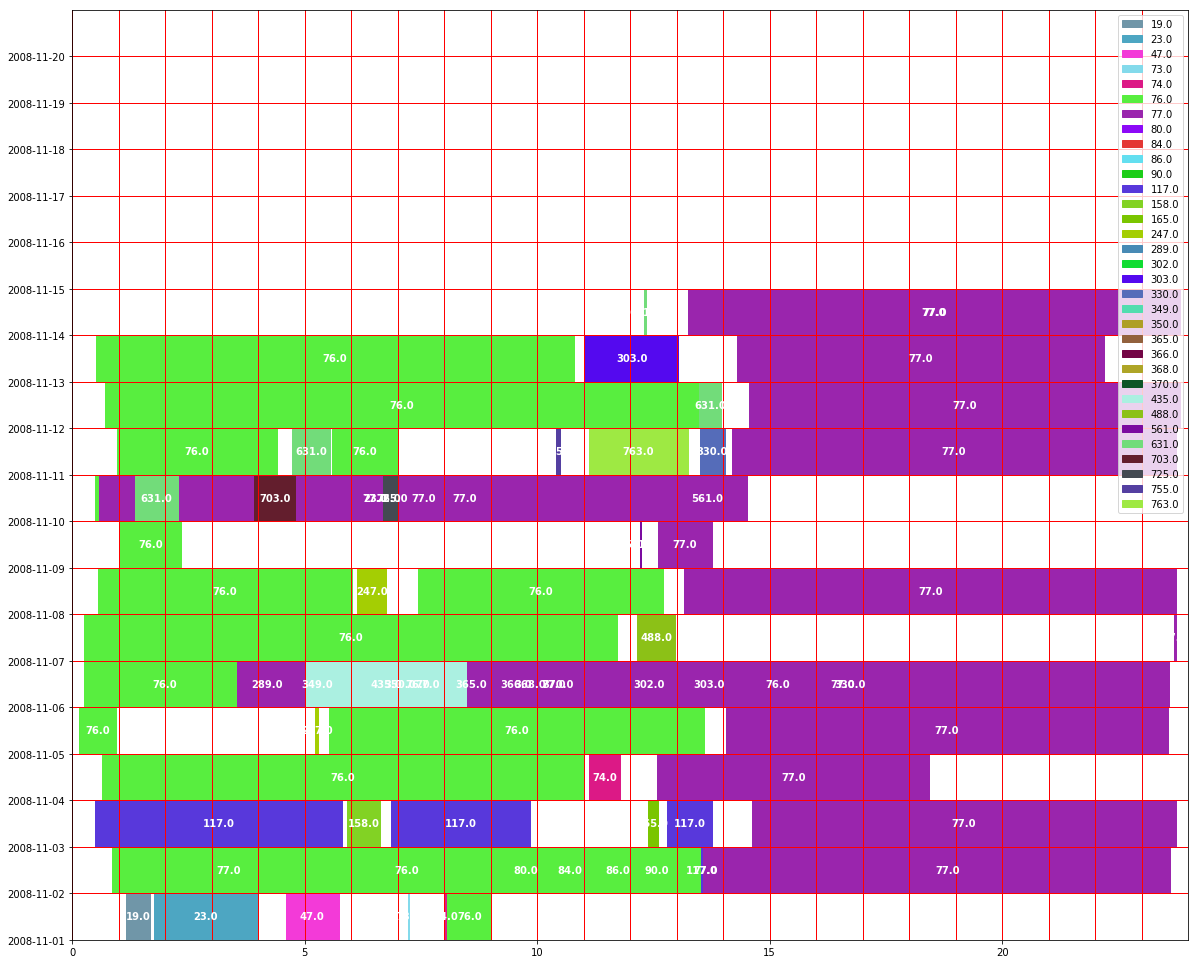

In [15]:
dicts = {}
clu_list = []
clu_list = staypts_df['StateId'].unique()
r = lambda: random.randint(0,255)
#olors = sns.color_palette("Paired", len(clu_list))

for i in range(0, len(clu_list)):
    #icts[clu_list[i]] = (colors[i])
    dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))

#create a new graph where we will later add rectangles for each hour:cluster
fig2 = plt.figure(figsize=(20,20))
ax1 = fig2.add_subplot(111, aspect='equal')

#get all the dates for y axis
date_list = staypts_df['StateEnd'].dt.date.unique()
y = range(0, len(date_list))
def_yticks = date_list
plt.yticks(y, def_yticks)

#set the x axis limit from 0-24 hours of a day, y axis with dates
limsx = (0, 24)
limsy = (0, len(date_list))

date_counter = 0
last_date = staypts_df.loc[0, 'StateStart'].date()

#drawing verical lines for each hour
for i in range(0, 24):
    ax1.axvline(x= i, linewidth=1, color='r')
for i in range(0, staypts_df['StateEnd'].dt.date.nunique()):
    ax1.axhline(y= i, linewidth=1, color='r')
    
i = 0
start_time_arr = [] 
end_time_arr = []
#for i in range(0, len(staypts_df)):
while i<len(staypts_df):
    start_time_arr = [] 
    end_time_arr = []
    
    last_state = staypts_df.loc[i, 'StateId']
    start_time_arr= np.append(start_time_arr, staypts_df.loc[i, 'StateStart'])
    end_time_arr= np.append(end_time_arr, staypts_df.loc[i, 'StateEnd'])

    #import pdb; pdb.set_trace()
    if i != 0:
        if staypts_df.loc[i, 'StateStart'].date() != staypts_df.loc[i-1, 'StateStart'].date():
            date_counter = date_counter + 1

    for j in range(i+1,len(staypts_df)):
        if staypts_df.loc[j, 'StateId'] == last_state:

            start_time_arr= np.append(start_time_arr, staypts_df.loc[i, 'StateStart'])
            end_time_arr= np.append(end_time_arr, staypts_df.loc[i, 'StateEnd'])
        else:
            i=j-1
            break
            
    start = min(start_time_arr)    
    end = max(end_time_arr)
    
    days = (end - start).days
    
    if days != 0:
        a = (start.hour + start.minute/60)
        b = 24
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                 color='w', weight='bold', fontsize=10, ha='center', va='center')

        #day 2 rectangle
        a = 0
        b = (end.hour + end.minute/60)
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter+1), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter+1), 
                 color='w', weight='bold', fontsize=10, ha='center', va='center')

    if (days == 0):
        a = (start.hour + start.minute/60)
        b = (end.hour + end.minute/60)
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')

    i = i + 1

handles, labels = ax1.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)

plt.xlim(limsx)
plt.ylim(limsy)
plt.show()

In [4]:
staypts_df

,StayptId,StayMeanLat,StayMeanLon,StartTimestamp,EndTimestamp,StateId,StateMeanLat,StateMeanLon,StateStart,StateEnd
0,19.0,40.069728,116.330728,2008-11-01 01:10:00,2008-11-01 01:39:00,19.0,40.069728,116.330728,2008-11-01 01:10:00.000000,2008-11-01 01:40:38.201767
1,23.0,40.074957,116.341682,2008-11-01 01:48:00,2008-11-01 01:48:00,23.0,40.074986,116.342950,2008-11-01 01:46:21.798233,2008-11-01 03:58:00.000000
2,24.0,40.074895,116.341730,2008-11-01 03:58:00,2008-11-01 03:58:00,23.0,40.074986,116.342950,2008-11-01 03:58:00.000000,2008-11-01 03:59:01.379877
3,47.0,40.013874,116.306429,2008-11-01 04:36:00,2008-11-01 05:43:00,47.0,40.013874,116.306429,2008-11-01 04:36:00.000000,2008-11-01 05:44:10.521259
4,73.0,39.903385,116.419932,2008-11-01 07:15:00,2008-11-01 07:15:00,73.0,39.903385,116.419932,2008-11-01 07:13:49.478741,2008-11-01 07:15:49.043554
5,74.0,39.975451,116.331571,2008-11-01 08:00:00,2008-11-01 08:00:00,74.0,39.974953,116.331919,2008-11-01 08:00:00.000000,2008-11-01 08:04:02.140333
6,76.0,39.978024,116.327564,2008-11-01 08:09:00,2008-11-01 08:09:00,76.0,39.977306,116.327396,2008-11-01 08:04:57.859667,2008-11-01 09:01:10.598430
7,77.0,40.013760,116.306470,2008-11-02 03:08:00,2008-11-02 03:08:00,77.0,40.013854,116.306511,2008-11-02 03:08:00.000000,2008-11-02 03:36:00.000000
8,78.0,40.013825,116.306527,2008-11-02 03:36:00,2008-11-02 03:36:00,77.0,40.013854,116.306511,2008-11-02 03:08:00.000000,2008-11-02 04:19:00.000000
9,79.0,40.013803,116.306475,2008-11-02 04:19:00,2008-11-02 04:19:00,77.0,40.013854,116.306511,2008-11-02 04:19:00.000000,2008-11-02 04:19:00.000000


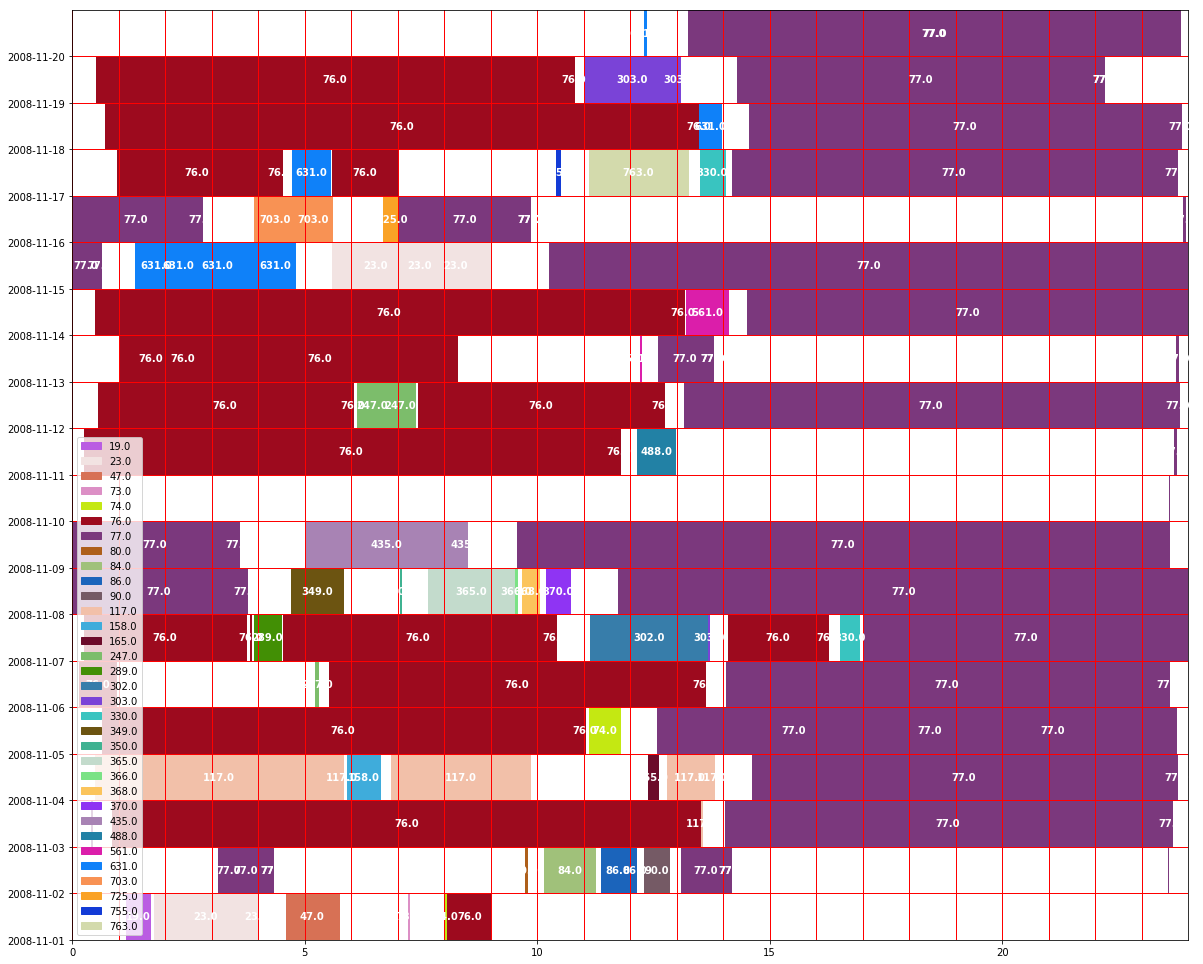

In [17]:
dicts = {}
clu_list = []
clu_list = staypts_df['StateId'].unique()
r = lambda: random.randint(0,255)
#olors = sns.color_palette("Paired", len(clu_list))

for i in range(0, len(clu_list)):
    #icts[clu_list[i]] = (colors[i])
    dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))

#create a new graph where we will later add rectangles for each hour:cluster
fig2 = plt.figure(figsize=(20,20))
ax1 = fig2.add_subplot(111, aspect='equal')

#get all the dates for y axis
date_list = staypts_df['StateEnd'].dt.date.unique()
y = range(0, len(date_list))
def_yticks = date_list
plt.yticks(y, def_yticks)

#set the x axis limit from 0-24 hours of a day, y axis with dates
limsx = (0, 24)
limsy = (0, len(date_list))

date_counter = 0
last_date = staypts_df.loc[0, 'StateStart'].date()

#drawing verical lines for each hour
for i in range(0, 24):
    ax1.axvline(x= i, linewidth=1, color='r')

for i in range(0, len(staypts_df)):
    #import pdb; pdb.set_trace()

    if (last_date != staypts_df.loc[i, 'StateStart'].date()):
        date_counter = date_counter + 1
        last_date = staypts_df.loc[i, 'StateStart'].date()
        ax1.axhline(y= date_counter, linewidth=1, color='r')

    #if the trajectory is going to next day
    if (staypts_df['StateStart'][i].date() !=
       staypts_df['StateEnd'][i].date()):
        #day 1 rectangle
        a = (staypts_df['StateStart'][i].hour + 
         staypts_df['StateStart'][i].minute/60)
        b = 24
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                 color='w', weight='bold', fontsize=10, ha='center', va='center')

        #day 2 rectangle
        a = 0
        b = (staypts_df['StateEnd'][i].hour + 
         staypts_df['StateEnd'][i].minute/60)
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter+1), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter+1), 
                 color='w', weight='bold', fontsize=10, ha='center', va='center')

    if (staypts_df['StateStart'][i].date() ==
       staypts_df['StateEnd'][i].date()):    
        a = (staypts_df['StateStart'][i].hour + 
             staypts_df['StateStart'][i].minute/60)
        b = (staypts_df['StateEnd'][i].hour +
            staypts_df['StateEnd'][i].minute/60)
        width = b - a
        height = 1
        col_id = dicts.get(staypts_df['StateId'][i])
        ax1.add_patch(patches.Rectangle((a, date_counter), width, height, 
                                        color=col_id, label=staypts_df['StateId'][i]))
        ax1.annotate(staypts_df['StateId'][i], (a + width/2, height/2 + date_counter), 
                     color='w', weight='bold', fontsize=10, ha='center', va='center')



handles, labels = ax1.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)

plt.xlim(limsx)
plt.ylim(limsy)
plt.show()